# Image Classification Using Swin Transformers


**Swin Transformer (Shifted Window Transformer)** can serve as a general-purpose backbone for computer vision. Swin Transformer is a hierarchical Transformer whose representations are computed with shifted windows. The shifted window scheme brings greater efficiency by limiting self-attention computation to non-overlapping local windows while also allowing for cross-window connections. This architecture has the flexibility to model information at various scales and has a linear computational complexity with respect to image size.

References:
1. Paper: https://arxiv.org/abs/2103.14030v2

# Download the files 💾¶
## Download AIcrowd CLI
We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.

In [ ]:
!pip install albumentations==0.4.6
!pip install timm

In [1]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

     |████████████████████████████████| 431 kB 4.3 MB/s 
     |████████████████████████████████| 50 kB 2.7 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 38.5 MB/s 
     |████████████████████████████████| 54 kB 642 kB/s 
     |████████████████████████████████| 170 kB 37.8 MB/s 
     |████████████████████████████████| 214 kB 34.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 51 kB 6.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 22.3.0
    Uninstalling pyzmq-22.3.0:
      Successfully uninstalled pyzmq-22.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


## Login to AIcrowd ㊗¶

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/-ZYQOWanddAIxSWVSYf08iACctbVXCLeCNNh0gQXdxk
API Key valid
Gitlab access token valid
Saved details successfully!


## Download Dataset¶
We will create a folder name data and download the files there.

In [3]:
!mkdir data
%aicrowd ds dl -c age-prediction -o data

sample_submission.csv:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/176M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/48.3k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/236M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/117M [00:00<?, ?B/s]

In [4]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

In [6]:
!rm /content/data/test.zip
!rm /content/data/train.zip
!rm /content/data/val.zip

In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
data_dir = "./data"

In [4]:
train = pd.read_csv(os.path.join(data_dir,"train.csv"))
val = pd.read_csv(os.path.join(data_dir,"val.csv"))
test = pd.read_csv(os.path.join(data_dir,"test.csv"))
sample = pd.read_csv(os.path.join(data_dir,"sample_submission.csv"))

# Duplicate Image filename in validation & train dataset
val = val.drop([463]).reset_index(drop=True)
train = pd.concat([train,val]).reset_index(drop=True)

train.shape,test.shape, sample.shape

((5999, 2), (3000, 2), (3000, 2))

## Target Class Mapping

In [5]:
label_2_id = {'0-10': 0,
             '10-20':1,
             '20-30':2,
             '30-40':3,
             '40-50':4,
             '50-60':5,
             '60-70':6,
             '70-80':7,
             '80-90':8,
             '90-100':9
            }

id_2_label = {0: '0-10',
             1: '10-20',
             2: '20-30',
             3: '30-40',
             4: '40-50',
             5: '50-60',
             6: '60-70',
             7: '70-80',
             8: '80-90',
             9: '90-100'}

train['age'] = train['age'].map(label_2_id)
test['age'] = test['age'].map(label_2_id)

In [6]:
train['ImageID'] = train['ImageID'].apply(lambda x: x+".jpg")
test['ImageID'] = test['ImageID'].apply(lambda x: x+".jpg")

In [7]:
train.head()

ImageID  age
0  93vu1.jpg    3
1  yjifi.jpg    8
2  ldd2k.jpg    9
3  eiwe0.jpg    4
4  sc0bp.jpg    0

In [8]:
test.head()

ImageID  age
0  8rti7.jpg    4
1  575pj.jpg    3
2  6ma92.jpg    3
3  jtu3e.jpg    2
4  svx4s.jpg    1

In [9]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

TRAIN_PATH = './data/train'
TEST_PATH = './data/test'

In [28]:
# ====================================================
# CFG
# ====================================================
model_name = 'swin_base_patch4_window12_384'
class CFG:
    apex=False
    print_freq=100
    model_name='resnext50_32x4d'
    size=384
    scheduler='CosineAnnealingWarmRestarts' 
    epochs=1
    T_0=10 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=4
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    target_size=10
    target_col='age'
    n_fold=3
    trn_fold=[0, 1, 2]
    train=True
    inference=True

In [11]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )

from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

if CFG.apex:
    from apex import amp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return f1_score(y_true, y_pred,average='micro')


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [13]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  age
0     0      191
      1      173
      2      176
      3      179
      4      181
      5      183
      6      185
      7      181
      8      188
      9      363
1     0      190
      1      173
      2      176
      3      179
      4      182
      5      184
      6      186
      7      180
      8      188
      9      362
2     0      191
      1      172
      2      176
      3      178
      4      181
      5      184
      6      186
      7      180
      8      189
      9      362
dtype: int64


In [14]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['ImageID'].values
        self.labels = df['age'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['ImageID'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TEST_PATH}/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

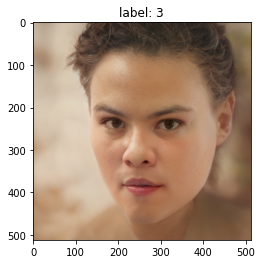

In [15]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

In [16]:
import albumentations
class CutoutV2(albumentations.DualTransform):
    def __init__(
        self,
        num_holes=8,
        max_h_size=8,
        max_w_size=8,
        fill_value=0,
        always_apply=False,
        p=0.5,
    ):
        super(CutoutV2, self).__init__(always_apply, p)
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.fill_value = fill_value

    def apply(self, image, fill_value=0, holes=(), **params):
        return albumentations.functional.cutout(image, holes, fill_value)

    def get_params_dependent_on_targets(self, params):
        img = params["image"]
        height, width = img.shape[:2]

        holes = []
        for _n in range(self.num_holes):
            y = random.randint(0, height)
            x = random.randint(0, width)

            y1 = np.clip(y - self.max_h_size // 2, 0, height)
            y2 = np.clip(y1 + self.max_h_size, 0, height)
            x1 = np.clip(x - self.max_w_size // 2, 0, width)
            x2 = np.clip(x1 + self.max_w_size, 0, width)
            holes.append((x1, y1, x2, y2))

        return {"holes": holes}

    @property
    def targets_as_params(self):
        return ["image"]

    def get_transform_init_args_names(self):
        return ("num_holes", "max_h_size", "max_w_size")

In [17]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

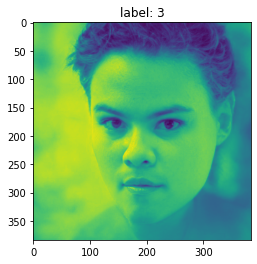

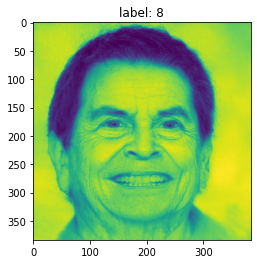

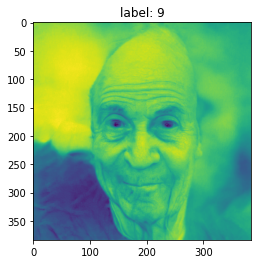

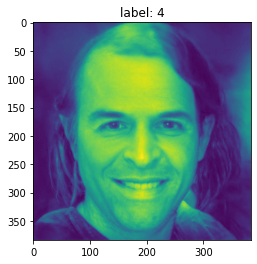

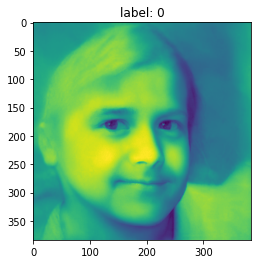

In [18]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

In [23]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          pin_memory=True, drop_last=True)

In [24]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [25]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              pin_memory=True, drop_last=True)#num_workers=CFG.num_workers, 
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                               pin_memory=True, drop_last=False) #num_workers=CFG.num_workers,
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = timm.create_model(model_name, pretrained=True,num_classes=10)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values
        
        if isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')

    return valid_folds

In [29]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
        # CV result
        LOGGER.info(f"========== CV ==========")
    
    if CFG.inference:
        
        # inference
        model = timm.create_model(model_name, pretrained=True,num_classes=10)
        MODEL_DIR = "./"
        states = [torch.load(MODEL_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in [0,1,2]]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                  pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        test['pred0'] = predictions[:,0]
        test['pred1'] = predictions[:,1]
        test['pred2'] = predictions[:,2]
        test['pred3'] = predictions[:,3]
        test['pred4'] = predictions[:,4]
        test['pred5'] = predictions[:,5]
        test['pred6'] = predictions[:,6]
        test['pred7'] = predictions[:,7]
        test['pred8'] = predictions[:,8]
        test['pred9'] = predictions[:,9]
        
        # submission
        test['age'] = predictions.argmax(1)
        test['age'] = test['age'].map(id_2_label)
        test['ImageID'] = test['ImageID'].apply(lambda x: x.split(".")[0] )
        
        test[['ImageID', 'age']].to_csv(os.path.join("assets", "submission.csv"), index=False)

In [30]:
!rm -rf assets
!mkdir assets

In [31]:
if __name__ == '__main__':
    main()

========== fold: 0 training ==========


Epoch: [1][0/999] Data 0.078 (0.078) Elapsed 0m 1s (remain 24m 48s) Loss: 1.4705(1.4705) Grad: 17.7823  
Epoch: [1][100/999] Data 0.040 (0.044) Elapsed 1m 51s (remain 16m 31s) Loss: 1.1296(1.7599) Grad: 13.0137  
Epoch: [1][200/999] Data 0.040 (0.049) Elapsed 3m 45s (remain 14m 54s) Loss: 2.1194(1.5369) Grad: 18.1125  


KeyboardInterrupt: ignored

# Submitting our Predictions
Note : Please save the notebook before submitting it (Ctrl + S)

In [ ]:
%aicrowd notebook submit -c age-prediction -a assets --no-verify